### Creating and testing magnetic dipoles and grid system

In [6]:
"""
IMPORTS AND CONFIG OPTIONS - CAN IGNORE THIS BOX
"""
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from Modules.muon import Muon
from Modules.positron import Positron
import Modules.functions as func

from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit

# Setting graph defaults to avoid repetition on each plot
mpl.rcParams["axes.formatter.limits"] = -2, 2  # Sets xticks to use exponents
mpl.rcParams["axes.grid"] = True  # Turns grid on
mpl.rcParams["legend.loc"] = "best"  # Turns legend on and autoplaces it

### Dipole class
Creates a dipole of some length, with a given orientation and a set strength
The magnetic moment "m" is calculated by:
$m = pI$<br>
Where $p$ is the strength of the poles
and $I$ is the vector separating them (length and orientation)<br>

The method "get_mag_field()" returns the magnetic field due to the dipole at a given point in space.

In [7]:
class Dipole(object):
    """
    Creates dipole:
    location = (pos_x, pos_y)
    orientation and length = pole_separation
    """
    count = 0
    def __init__(self, orientation, location, strength):
        """
        Init object: pole_separation and location should be 2d arrays
        """
        self.location = np.array(location)
        self.orientation_d = orientation
        self.orientation_r = np.deg2rad(orientation)
        self.strength = strength
        self.moment = np.array([strength * np.cos(self.orientation_r), strength * np.sin(self.orientation_r), 0])
        Dipole.count += 1

    def __repr__(self):
        """Sets string representation of the instance"""
        return ("Dipole object:  Location: {}\n\
                Orientation: {:.2f} degrees\n\
                Strength: {:.3e} T\n\
                Moment: {}".format(self.location, self.orientation_d, self.strength, self.moment))

    def get_mag_field(self, target):
        """Gets magnetic field at target location (x, y, z)"""
        # Check that coordinates are same dimension
        if not len(target)==len(self.location):
            raise ValueError("Target location and dipole location must be given in the same dimensions")
        mag_perm = 10**-7  # Cancel constant terms to get mag_perm as only constant
        relative_loc = np.subtract(np.array(target), self.location)
        magnitude = get_mag(relative_loc)
        return mag_perm * (
                (3*relative_loc*(np.dot(self.moment, relative_loc)) / (magnitude**5))
                - (self.moment / (magnitude**3))
                )

    def get_relative_loc(self, other):
        return other.location - self.location


### Grid class (WiP)
Creates a grid into which the dipoles can be placed


In [8]:
class Grid(object):
    def __init__(self, width, height):
        self.width = width
        self.height = height
    
    def __repr__(self):
        #widthheight = f"Width: {self.width}, Height: {self.height}"
        #rowscols = f"x points: {self.cols}, y points: {self.rows}"
        #return widthheight + "\n" + rowscols
        return str(self.points)
    
    def add_points(self, x_points, y_points):
        self.cols = np.linspace(0, self.width, x_points)
        self.rows = np.linspace(0, self.height, y_points)
        self.points = np.zeros([x_points, y_points])

# g = Grid(100, 100)
# g.add_points(2, 2)
# print(g)

# x_ar = np.linspace(-5, 5, 11)
# y_ar = np.linspace(-5, 5, 11)
# B = np.zeros([11, 11])
# for x in x_ar:
#     x = int(x)
#     for y in y_ar:
#         y = int(y)
#         B[x], B = dipole_field([x, y], 1)

# print(B)

### General functions

In [9]:
def get_unit(vector):
    norm = np.linalg.norm(vector)
    if norm == 0: 
       return vector
    return vector / norm
def get_mag(vector):
    return np.sqrt(vector.dot(vector))
def get_dir_2d(vector):
    return np.arctan(vector[1]/vector[0])

### Creating and testing a single dipole

In [11]:
# Create a dipole
dip_1 = Dipole(orientation=0, location=[0, 0, 0], strength=1e-3)

# Creating an x,y grid to test magnetic field on
Nx, Ny = 100, 100
side_length = 5e-4
x_grid = np.linspace(-side_length, side_length, Nx)
y_grid = np.linspace(-side_length, side_length, Ny)

# Creating grids to store the field values and directions
field_x = np.zeros([Nx, Ny])
field_y = np.zeros_like(field_x)

# Loop over points in grid and get field at each point
try:
    for i, x in enumerate(x_grid):
        for j, y in enumerate(y_grid):
            field_at_point = dip_1.get_mag_field(target=[x, y, 100e-6])
            field_x[i][j] = field_at_point[0]
            field_y[i][j] = field_at_point[1]
except TypeError as e:
    print("======ERROR======")
    print("i, x", i, x)
    print("j, y", j, y)
    print(field_at_point)
    raise

# Some values are coming up as inf due to divide by zero errors
# Current work around is to change inf to an arbitrary large number

# Seems this is no longer necessary when the number of grid points increases
#field_x = np.where(field_x == np.inf, 1e1, field_x)
#field_x = np.where(field_x == -np.inf, -1e1, field_x)
#field_y = np.where(field_y == np.inf, 1e1, field_y)
#field_y = np.where(field_y == -np.inf, -1e1, field_y)

### Plotting the field lines

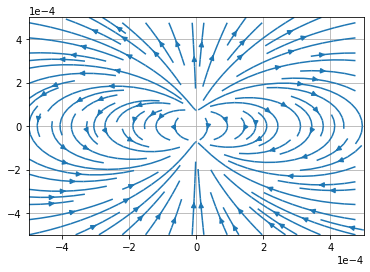

In [13]:
plt.figure
plt.streamplot(x_grid, y_grid, field_y, field_x, density=1)
plt.xlim(-side_length, side_length)
plt.ylim(-side_length, side_length)
plt.show()